# Homework set 5 Comp Econ
## Small-sample bias of OLS in AR(1) regression (in Julia)

**Author** Pierre Mabille 

**NYU ID** N10017621 

**Date** March 11, 2016 

In [1]:
addprocs(4)
using Distributions
using PyPlot

Define global parameters and check number of processors used for parallelizing.

In [2]:
alpha_vec = [.5  .6  .7  .8  .9] # array of alphas to loop through
Nrange = collect(50:50:500) # array of sample sizes to loop through
nprocs()


5

Define a function generating the time series $(X_t)_{t=0}^n$ for given first-order autocorrelation $\alpha$ and given sample size $n$:
$$X_{t+1} = \alpha x_t + \beta + \sigma W_{t+1}$$
$$W_{t+1} \stackrel{iid}{\sim} \mathcal{N}(0,1) $$

Also define a function computing the bias of the OLS estimation $\widehat{\alpha}$ as $\mathbb{E}\left[\widehat{\alpha} \right] - \alpha$. The expectation is approximated by a Monte-Carlo simulation of $N_{sim}$ draws. The OLS estimate is computed analytically in matrix form.

Define these two functions everywhere for parallelizing, so all workers know what they refer to. Parameters used to generate the series and compute the estimator bias are also defined everywhere.

In [3]:
@everywhere begin    

    Nsim = 10000 # simulation length for Monte-Carlo estimation of OLS estimator bias

    sigma = 5.0 # std. dev. normal shock
    beta = 1.0 # AR(1) constant

    function generate_series(alpha::Float64, beta::Float64, sigma::Float64, n::Int)
        x = Array(Float64,n+1)
        W = randn(n+1)
        x[1] = W[1]
        for t = 1:n
            x[t+1] = alpha*x[t] + beta + sigma*W[t+1]
        end
        return x
    end

    f1_to_pass(n,alpha) = generate_series(alpha, beta, sigma, n)
    
    function estimate_bias(alpha::Float64, n::Int64, Nsim::Int64) # estimate bias' expectation (Monte-Carlo approx) for given alpha and sample size n 
        
        sum_alphahat = 0.0

        for i =1:Nsim # Monte-Carlo approximation of the expectation of the OLS estimator
            Y = f1_to_pass(n,alpha)
            X = [ones(n) Y[1:n]]
            Y = Y[2:n+1]
            alphahat = inv(X'*X)*(X'*Y) # OLS regression 

            sum_alphahat = sum_alphahat + alphahat[2] 
        end

        return (sum_alphahat/Nsim - alpha)
    end        
    
    f2_to_pass(n,alpha) = estimate_bias(alpha, n, Nsim)
end

Call the functions in parallel using the pmap command (parallel map), for a given $\alpha$. Loop over $\alpha$'s and store the series of the estimator biases in an array. Thanks to parallelization and Julia's quick way of handling loops, the code runs fast.

In [6]:
bias = Array(Any,length(alpha_vec))
tic()
for i = 1:length(alpha_vec)
    bias[i] = pmap(f2_to_pass, Nrange, ones(length(Nrange))*alpha_vec[i])
end
toc()

elapsed time: 

1.833840757

1.833840757 seconds


Plot the series of biases. The same comments apply as for the previous homework.

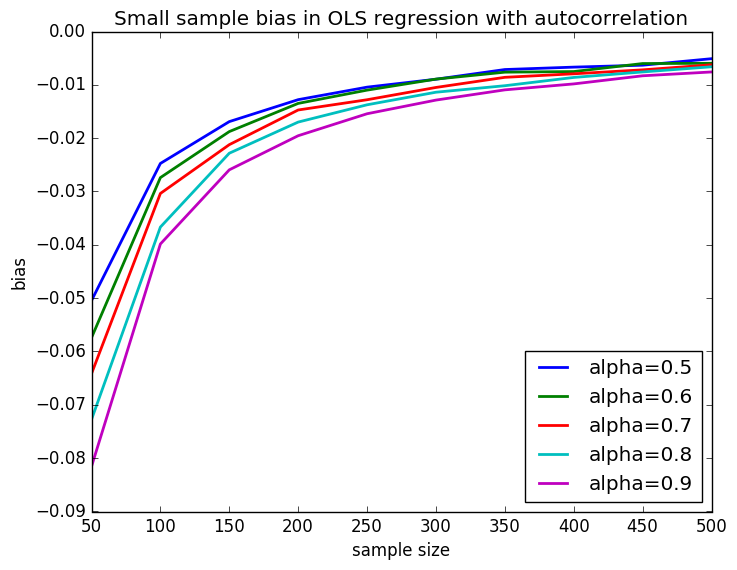

0-element Array{Any,1}

In [18]:
fig, ax = subplots()

for i in 1:length(alpha_vec)
    # == Plot current pdf == #
    alpha = alpha_vec[i]
    ax[:plot](Nrange, bias[i], linewidth=2, label="alpha=$alpha")
    
end
ax[:legend](loc="lower right")
ax[:set_title]("Small sample bias in OLS regression with autocorrelation")
ax[:set_xlabel]("sample size")
ax[:set_ylabel]("bias")
PyPlot.plot()